<a href="https://www.pyg.org/"><img src="https://raw.githubusercontent.com/pyg-team/pyg_sphinx_theme/master/pyg_sphinx_theme/static/img/pyg_logo_text.svg" width="400" height="120" alt="Weights & Biases" /></a><a href="https://wandb.ai/site"><img src="http://wandb.me/logo-im-png" width="900" height="120" alt="Weights & Biases" /></a>
<!--- @wandbcode{pytorch_geometric_graph_classification_example} -->

# Graph Classification with PyG and W&B

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://wandb.me/pyg-graph-classification)

In this notebook we will walk you through how you can make your geometric deep learning journey a little easier by using PyTorch Geoemtric in conjunction with Weights & Biases.

## Setup

In [ ]:
import os

In [ ]:
import torch
torch_version = torch.__version__.split("+")
os.environ["TORCH"] = torch_version[0]
os.environ["CUDA"] = torch_version[1]

We will start by installing the basic packages i.e. PyTorch Geometric for implementing our graph neural networks, plotly for easier visualization and W&B for tracking our experiments.

In [ ]:
%%capture
!pip install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-geometric
!pip install wandb
!pip install plotly
!pip install --upgrade scipy
!wget "https://gist.githubusercontent.com/mogproject/50668d3ca60188c50e6ef3f5f3ace101/raw/e11d5ac2b83fb03c0e5a9448ee3670b9dfcd5bf9/visualize.py"

Now let us import `wandb` and log in to your W&B account.

Now we will import all the packages that we will use as we progress through this example.

In [ ]:
# General imports
import os
import collections

# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import scipy.sparse as sp

# Import Weights & Biases for Experiment Tracking
import wandb

# Graph imports
import torch
from torch import Tensor
import torch.nn.functional as F

import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx

import networkx as nx
from networkx.algorithms import community

from tqdm.auto import trange

In [ ]:
#External helper packages
%run visualize.py
from visualize import GraphVisualization 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset and Exploratory Data Analysis

To start logging and tracking information with W&B, we will first initialize a run. This run will reside inside a project in your W&B profile and it will store everything related to this experiment which in this case is EDA.

In [ ]:
wandb_project = "intro_to_pyg" #@param {type:"string"}
wandb_run_name = "upload_and_analyze_dataset" #@param {type:"string"}

if use_wandb:
    wandb.init(project=wandb_project, name=wandb_run_name)

We will work on the [MUTAG](https://chrsmrrs.github.io/datasets/docs/datasets/) dataset for classifying graphs into one of two classes. Downloading and loading the graphs and labels from this dataset is supported internally by PyG.

In [ ]:
from torch_geometric.datasets import TUDataset
dataset_path = "data/TUDataset"
dataset = TUDataset(root=dataset_path, name='MUTAG')

dataset.download()

In [ ]:
data_details = {
    "num_node_features": dataset.num_node_features,
    "num_edge_features": dataset.num_edge_features,
    "num_classes": dataset.num_classes,
    "num_node_labels": dataset.num_node_labels,
    "num_edge_labels": dataset.num_edge_labels
}

# Log all the details about the data to W&B.
wandb.log(data_details) #🪄🐝

In the snippet below, we convert the PyG graph to a plotly figure for visualization.

In [ ]:
def create_graph(graph):
    g = to_networkx(graph)
    pos = nx.spring_layout(g)
    vis = GraphVisualization(g,
                            pos,
                            node_text_position='top left',
                            node_size=20,
                             )
    fig = vis.create_figure()
    return fig

fig = create_graph(dataset[0])
fig.show()

In order to perform EDA, we will log the input graphs along with the number of nodes, edges and the ground truth labels as a W&B Table.

In [ ]:
table = wandb.Table(columns=["Graph", "Number of Nodes", "Number of Edges", "Label"])
for graph in dataset:
    fig = create_graph(graph)
    n_nodes = graph.num_nodes
    n_edges = graph.num_edges
    label = graph.y.item()

    table.add_data(wandb.Html(plotly.io.to_html(fig)), n_nodes, n_edges, label)
wandb.log({"data": table})

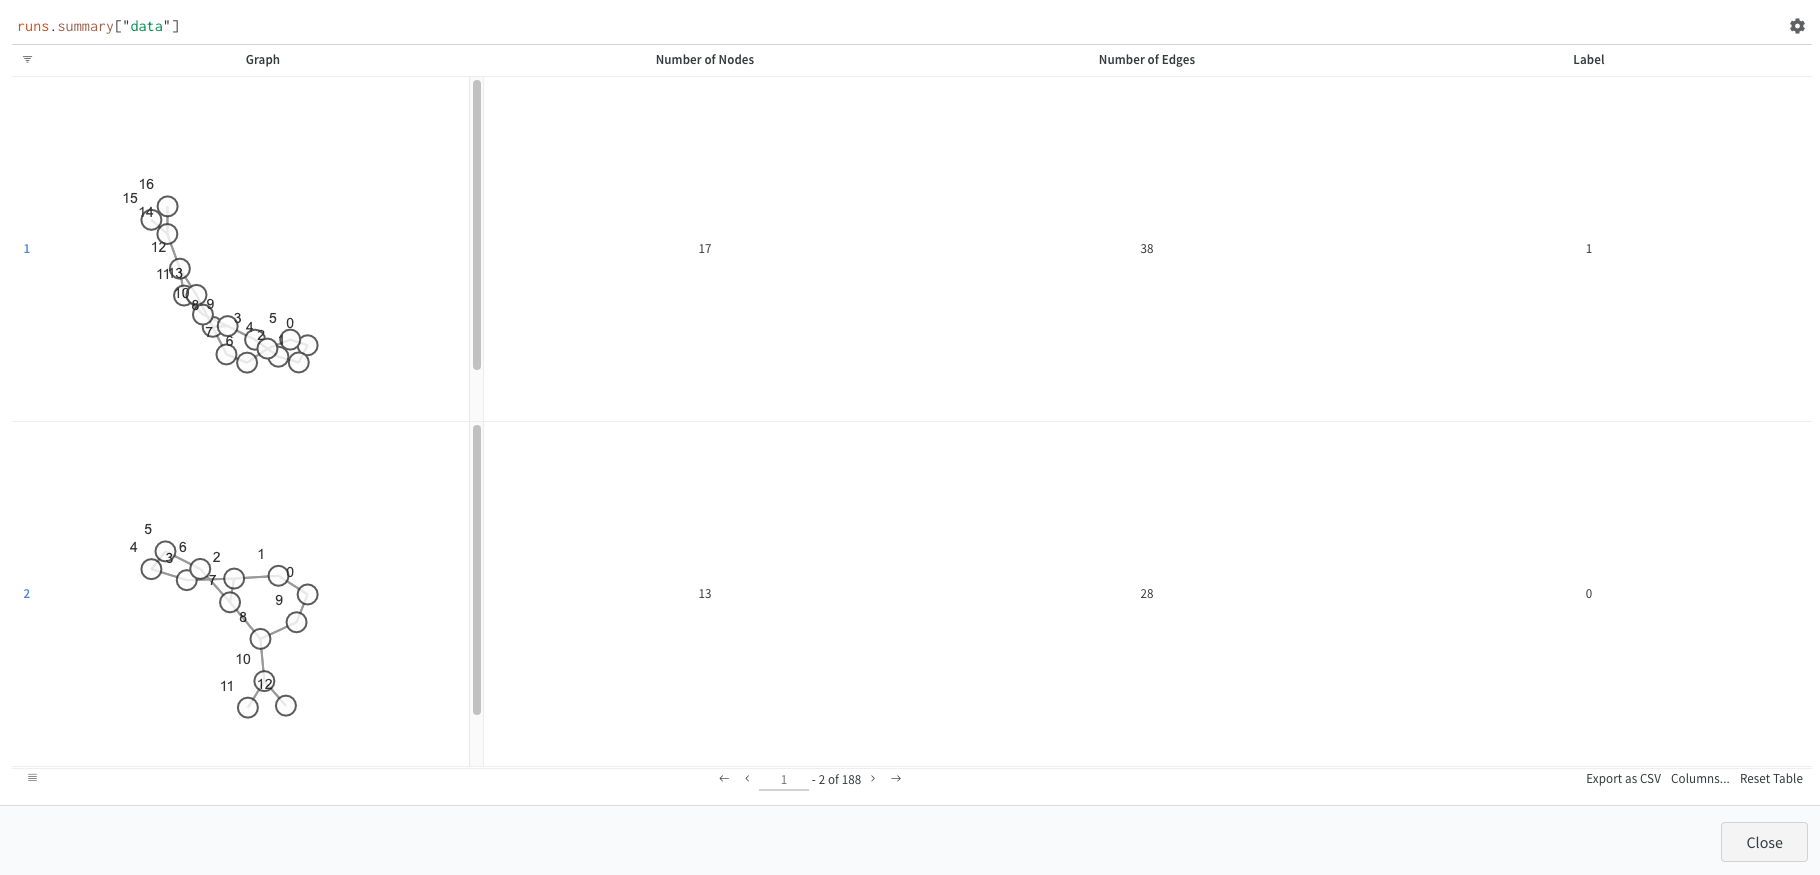

We would also like to log and track our dataset so we will add the downloaded dataset to a W&B artifact and log that as well.

In [ ]:
dataset_artifact = wandb.Artifact(name="MUTAG", type="dataset", metadata=data_details)
dataset_artifact.add_dir(dataset_path)
wandb.log_artifact(dataset_artifact)

In [ ]:
wandb.finish()

## Training the Model

### Creating Training and Testing Data

We shuffle the dataset and split it into training and testing sets

In [ ]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Let us create the dataloaders to effectively batch the graph inputs. Batching graphs is implemented extremely effectively in PyG and that has been used in this example.

In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

### Implementing the Model

To perform the classification, we use a very simple model with three graph convolution layers implemented in PyTorch Geometric.

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

### Training

In the following cell, start a new W&B run and using the `use_artifact` function, we tell W&B that the given artifact is being used as input to this run.

**Note:** Usage of Weights & Biases for training is optional, in case you don't wish to use it, simply uncheck `use_wandb`.

In [ ]:
use_wandb = True #@param {type:"boolean"}
wandb_project = "intro_to_pyg" #@param {type:"string"}
wandb_run_name = "upload_and_analyze_dataset" #@param {type:"string"}

# Initialize W&B run for training
if use_wandb:
    wandb.init(project="intro_to_pyg")
    wandb.use_artifact("manan-goel/intro_to_pyg/MUTAG:v0")

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

In the function in the cell below, we implement a function to calculate accuracy and loss on the test set but along with that we also create a W&B table which can be used to see the graph along with the output from the model and the ground truth label.
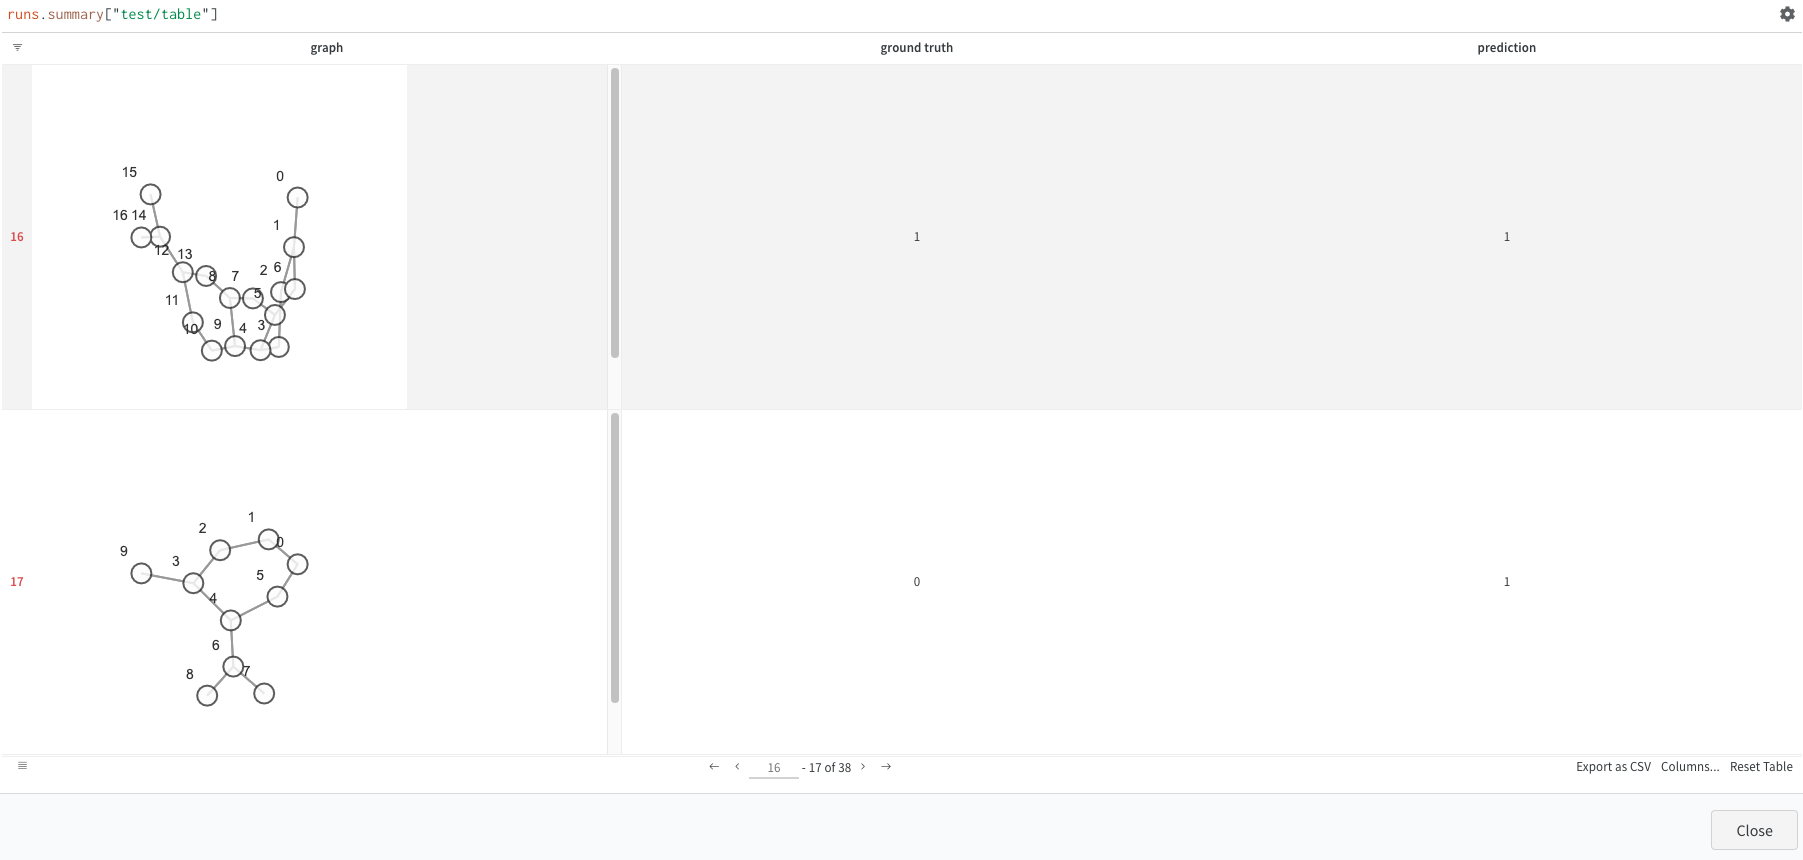

In [ ]:
def test(loader, create_table=False):
     model.eval()
     table = wandb.Table(columns=['graph', 'ground truth', 'prediction']) if use_wandb else None
     correct = 0
     loss_ = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         loss = criterion(out, data.y)
         loss_ += loss.item()
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         
         if create_table and use_wandb:
            table.add_data(wandb.Html(plotly.io.to_html(create_graph(data))), data.y.item(), pred.item())
         
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset), loss_ / len(loader.dataset), table  # Derive ratio of correct predictions.

The great thing about PyG is that all the code is very similar to PyTorch and you can use the same training logic which is what has been done in the following cell. We calculate the accuracy and loss on the training and validation sets and long them to our W&B dashboard. 

We also log the table that was mentioned above to the run dashboard for debugging.

In [ ]:
# Hook into the torch model to collect gradients and the topology and log them on W&B
if use_wandb:
    wandb.watch(model)

for epoch in trange(1, 171):
    train()
    train_acc, train_loss, _ = test(train_loader)
    test_acc, test_loss, test_table = test(test_loader, create_table=True)
    
    # Log metrics to W&B
    if use_wandb:
        wandb.log({
            "train/loss": train_loss,
            "train/acc": train_acc,
            "test/acc": test_acc,
            "test/loss": test_loss,
            "test/table": test_table
        })

    torch.save(model, "graph_classification_model.pt")
    
    # Log model checkpoint as an artifact to W&B
    if use_wandb:
        artifact = wandb.Artifact(name="graph_classification_model", type="model")
        artifact.add_file("graph_classification_model.pt")
        wandb.log_artifact(artifact)


# Finish the W&B run
if use_wandb:
    wandb.finish()

This is what the project dashboard looks like and you can interact with it i.e. make the panels larger or smaller and more!

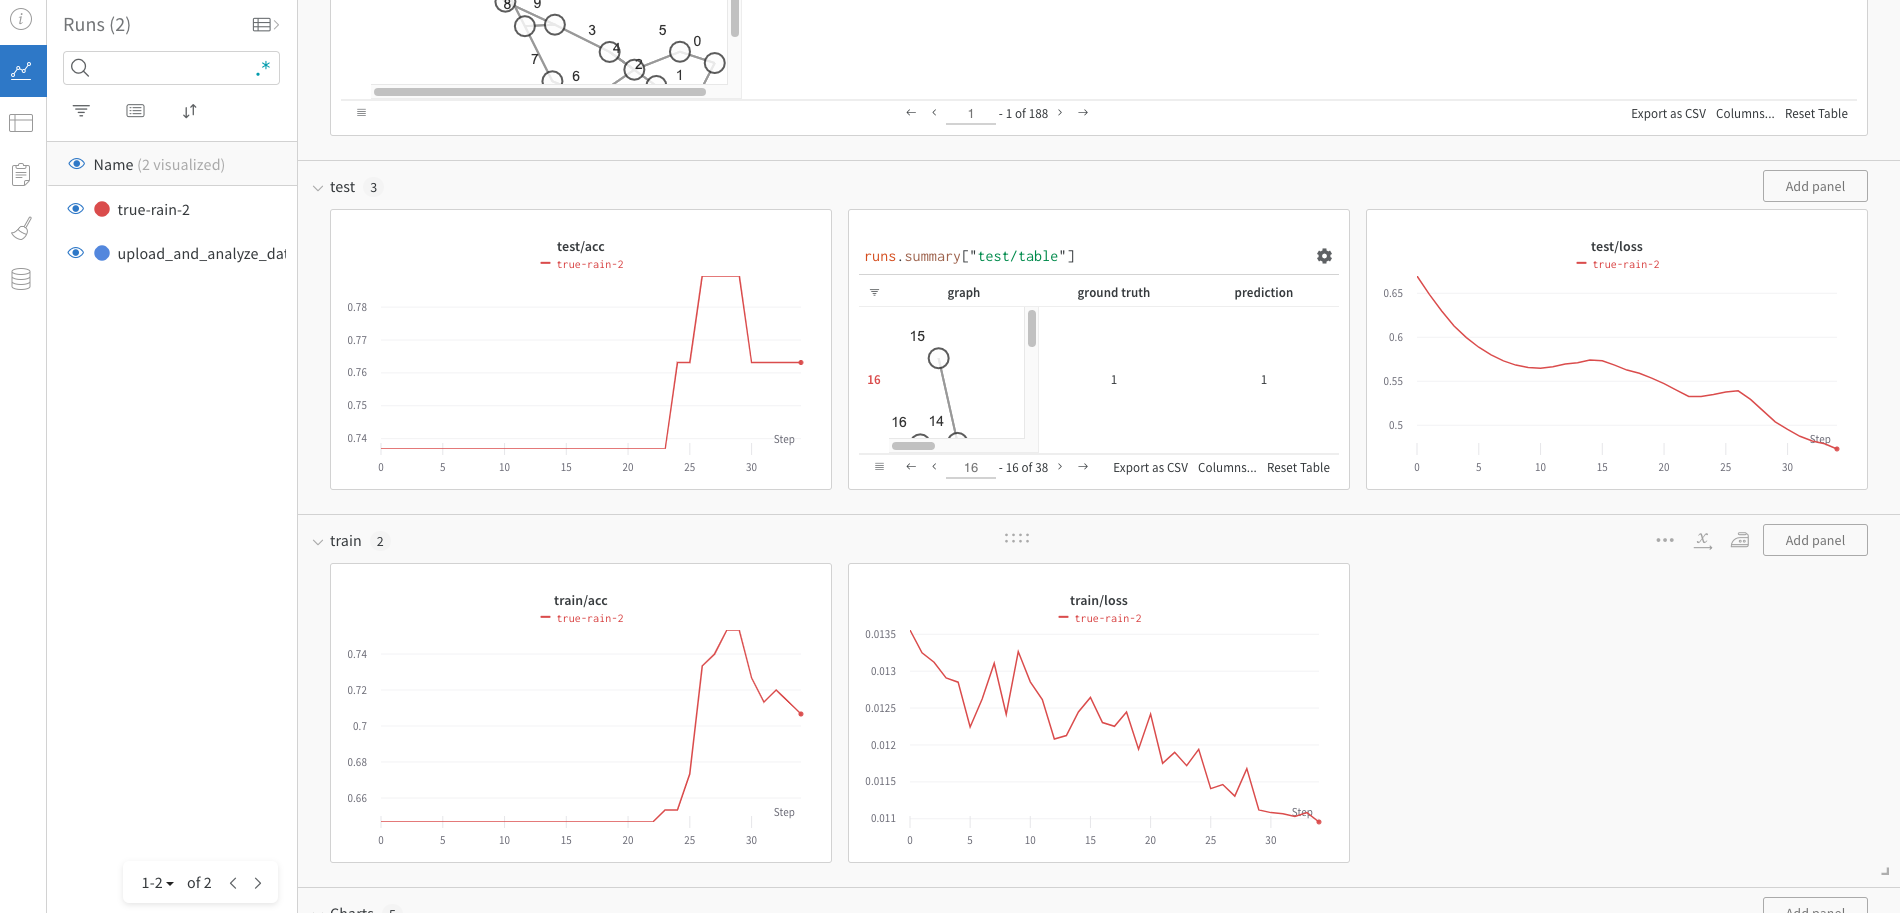

## 📚 Resources

* [Node Classification (with W&B)](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pyg/8_Node_Classification_(with_W%26B).ipynb) contains a few tips for taking most advantage of W&B with PyG
* [Point Cloud Classification using PyTorch Geometric](https://wandb.ai/geekyrakshit/pyg-point-cloud/reports/Point-Cloud-Classification-using-PyTorch-Geometric--VmlldzozMTExMTE3)
* [Recommending Amazon Products using Graph Neural Networks in PyTorch Geometric](https://wandb.ai/manan-goel/gnn-recommender/reports/Recommending-Amazon-Products-using-Graph-Neural-Networks-in-PyTorch-Geometric--VmlldzozMTA3MzYw)



## ❓ Questions about W&B

If you have any questions about using W&B to track your model performance and predictions, please contact support@wandb.com